In [1]:
import sys
sys.path.append('/p/home/jusers/kotobi2/juwels/hida_project/')

In [2]:
from attribution_gnn1.QM9_SpecData import QM9_SpecData
from utils.cams import cam_gnn
from src.models import SpectraGNN, SpectraGAT, SpectraGraphNet

from utils.graph_preprocessing import GraphDataProducer

import os.path as osp
from typing import List

import torch
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', palette='muted', font_scale=1.5)

from pylab import rc, rcParams
rc('text', usetex=False)
rc('axes', linewidth=2)
rc('font', weight='normal')

params = {'legend.fontsize': 5,
          'figure.figsize': (18, 16),
         'axes.labelsize': 27,
         'axes.titlesize': 25,
         'xtick.labelsize':27,
         'ytick.labelsize':27,
         'figure.dpi' : 300}
rcParams.update(params)

# Models 

In [3]:
device = 'cpu'

In [22]:
spectragnn = SpectraGNN(
    gnn_name='gatv2',
    in_channels=[11, 128, 256, 512],
    out_channels=[128, 256, 512, 600],
    num_targets=100,
    num_layers=4,
    heads=3
).to(device)

# loading the saved model 
path_to_model = osp.join('/p/home/jusers/kotobi2/juwels/hida_project/trained_models/'\
                         'models_diff_arch/spectragnn_50k_gatv2/best_model/', 
                         'spectragatv2_50k.pt')

if osp.exists(path_to_model):
    spectragnn.load_state_dict(torch.load(path_to_model))
else:
    print('model is not loaded')

In [4]:
spectragat = SpectraGAT(
    node_features_dim=11,
    in_channels=[128, 128, 128, 128],
    out_channels=[128, 128, 128, 400],
    targets=100,
    n_layers=4,
    n_heads=3,
    gat_type = 'gatv2_custom',
    use_residuals=True,
    use_jk=True
).to(device)

# loading the saved model 
path_to_saved_model = ('/p/home/jusers/kotobi2/juwels/hida_project/trained_models/'\
                       'models_diff_arch/spectragat_50k_gatv2cus/best_model/spectragatv2_50k.pt')
if osp.exists(path_to_saved_model):
    spectragat.load_state_dict(torch.load(path_to_saved_model))
else:
    print('model is not loaded')

In [4]:
node_model_params = {"feat_in": 42, "feat_hidd": 64, "feat_out": 50}   #39
edge_model_params = {"feat_in": 125, "feat_hidd": 64, "feat_out": 50} #124
global_model_params = {"feat_in": 120, "feat_hidd": 64, "feat_out": 50}

node_model_params1 = {"feat_in": 200, "feat_hidd": 64, "feat_out": 50}
edge_model_params1 = {"feat_in": 200, "feat_hidd": 64, "feat_out": 50}
global_model_params1 = {"feat_in": 150, "feat_hidd": 64, "feat_out": 50}

node_model_params2 = {"feat_in": 200, "feat_hidd": 64, "feat_out": 50}
edge_model_params2 = {"feat_in": 200, "feat_hidd": 64, "feat_out": 50}
global_model_params2 = {"feat_in": 150, "feat_hidd": 64, "feat_out": 50}

In [5]:
all_params = {"graphnet0": {"node_model_params": node_model_params,
            "edge_model_params": edge_model_params,
            "global_model_params": global_model_params,
            "gat_in": 12},
             
             "graphnet1": {"node_model_params": node_model_params1,
            "edge_model_params": edge_model_params1,
            "global_model_params": global_model_params1,
            "gat_in": 12},
             
             "graphnet2": {"node_model_params": node_model_params2,
            "edge_model_params": edge_model_params2,
            "global_model_params": global_model_params2,
            "gat_in": 12}}

In [6]:
spectragraphnet = SpectraGraphNet(all_params=all_params, n_layers=3, 
                                  lin_in=50, n_targets=100).to(device)

# loading the saved model 
path_to_model = ('/p/home/jusers/kotobi2/juwels/hida_project/trained_models/'\
                'models_diff_arch/spectragraphnet_50k_bl/best_model/spectragraphnet_50k_bl.pt')

if osp.exists(path_to_model):
    spectragraphnet.load_state_dict(torch.load(path_to_model))
else:
    print('model is not loaded')

# test data preparation and pick a graph

In [7]:
path_to_data = '/p/home/jusers/kotobi2/juwels/data_qm9/all_graph_data/qm9_spec_test_0-8eV_bl.pt'
test_data = QM9_SpecData(
            root=path_to_data,
            raw_dir='/p/home/jusers/kotobi2/juwels/data_qm9/raw/',
            spectra=[]
        )

In [6]:
mol_idx = 15482
graph_picker = GraphDataProducer(
    model=spectragnn,
    gnn_type="gcn",
    test_data=test_data,
    idx_to_pick=mol_idx
)
graph = graph_picker.picked_graph

In [82]:
graph 

Data(x=[13, 11], edge_index=[2, 26], edge_attr=[26, 4], pos=[13, 3], z=[13], spectrum=[100], idx=15482, batch=[13])

In [83]:
y_true = graph.spectrum
x_pred, y_pred = graph_picker.predictions()

# RSE on the test dataset 

In [8]:
from utils.rse import rse_predictions, rse_histogram, rse_loss

In [9]:
rse_dict = rse_predictions(spectragraphnet, test_data, graphnet=True)

In [10]:
rse_dict = {k: v.numpy() for k, v in rse_dict.items() if v < 1}

In [9]:
rse_loss(y_pred, y_true)

NameError: name 'y_pred' is not defined

In [33]:
pd.DataFrame.from_dict({'mol_idx': rse_dict.keys(), 
                        'RSE': rse_dict.values()}).to_csv('./RSE_graphNet.csv')

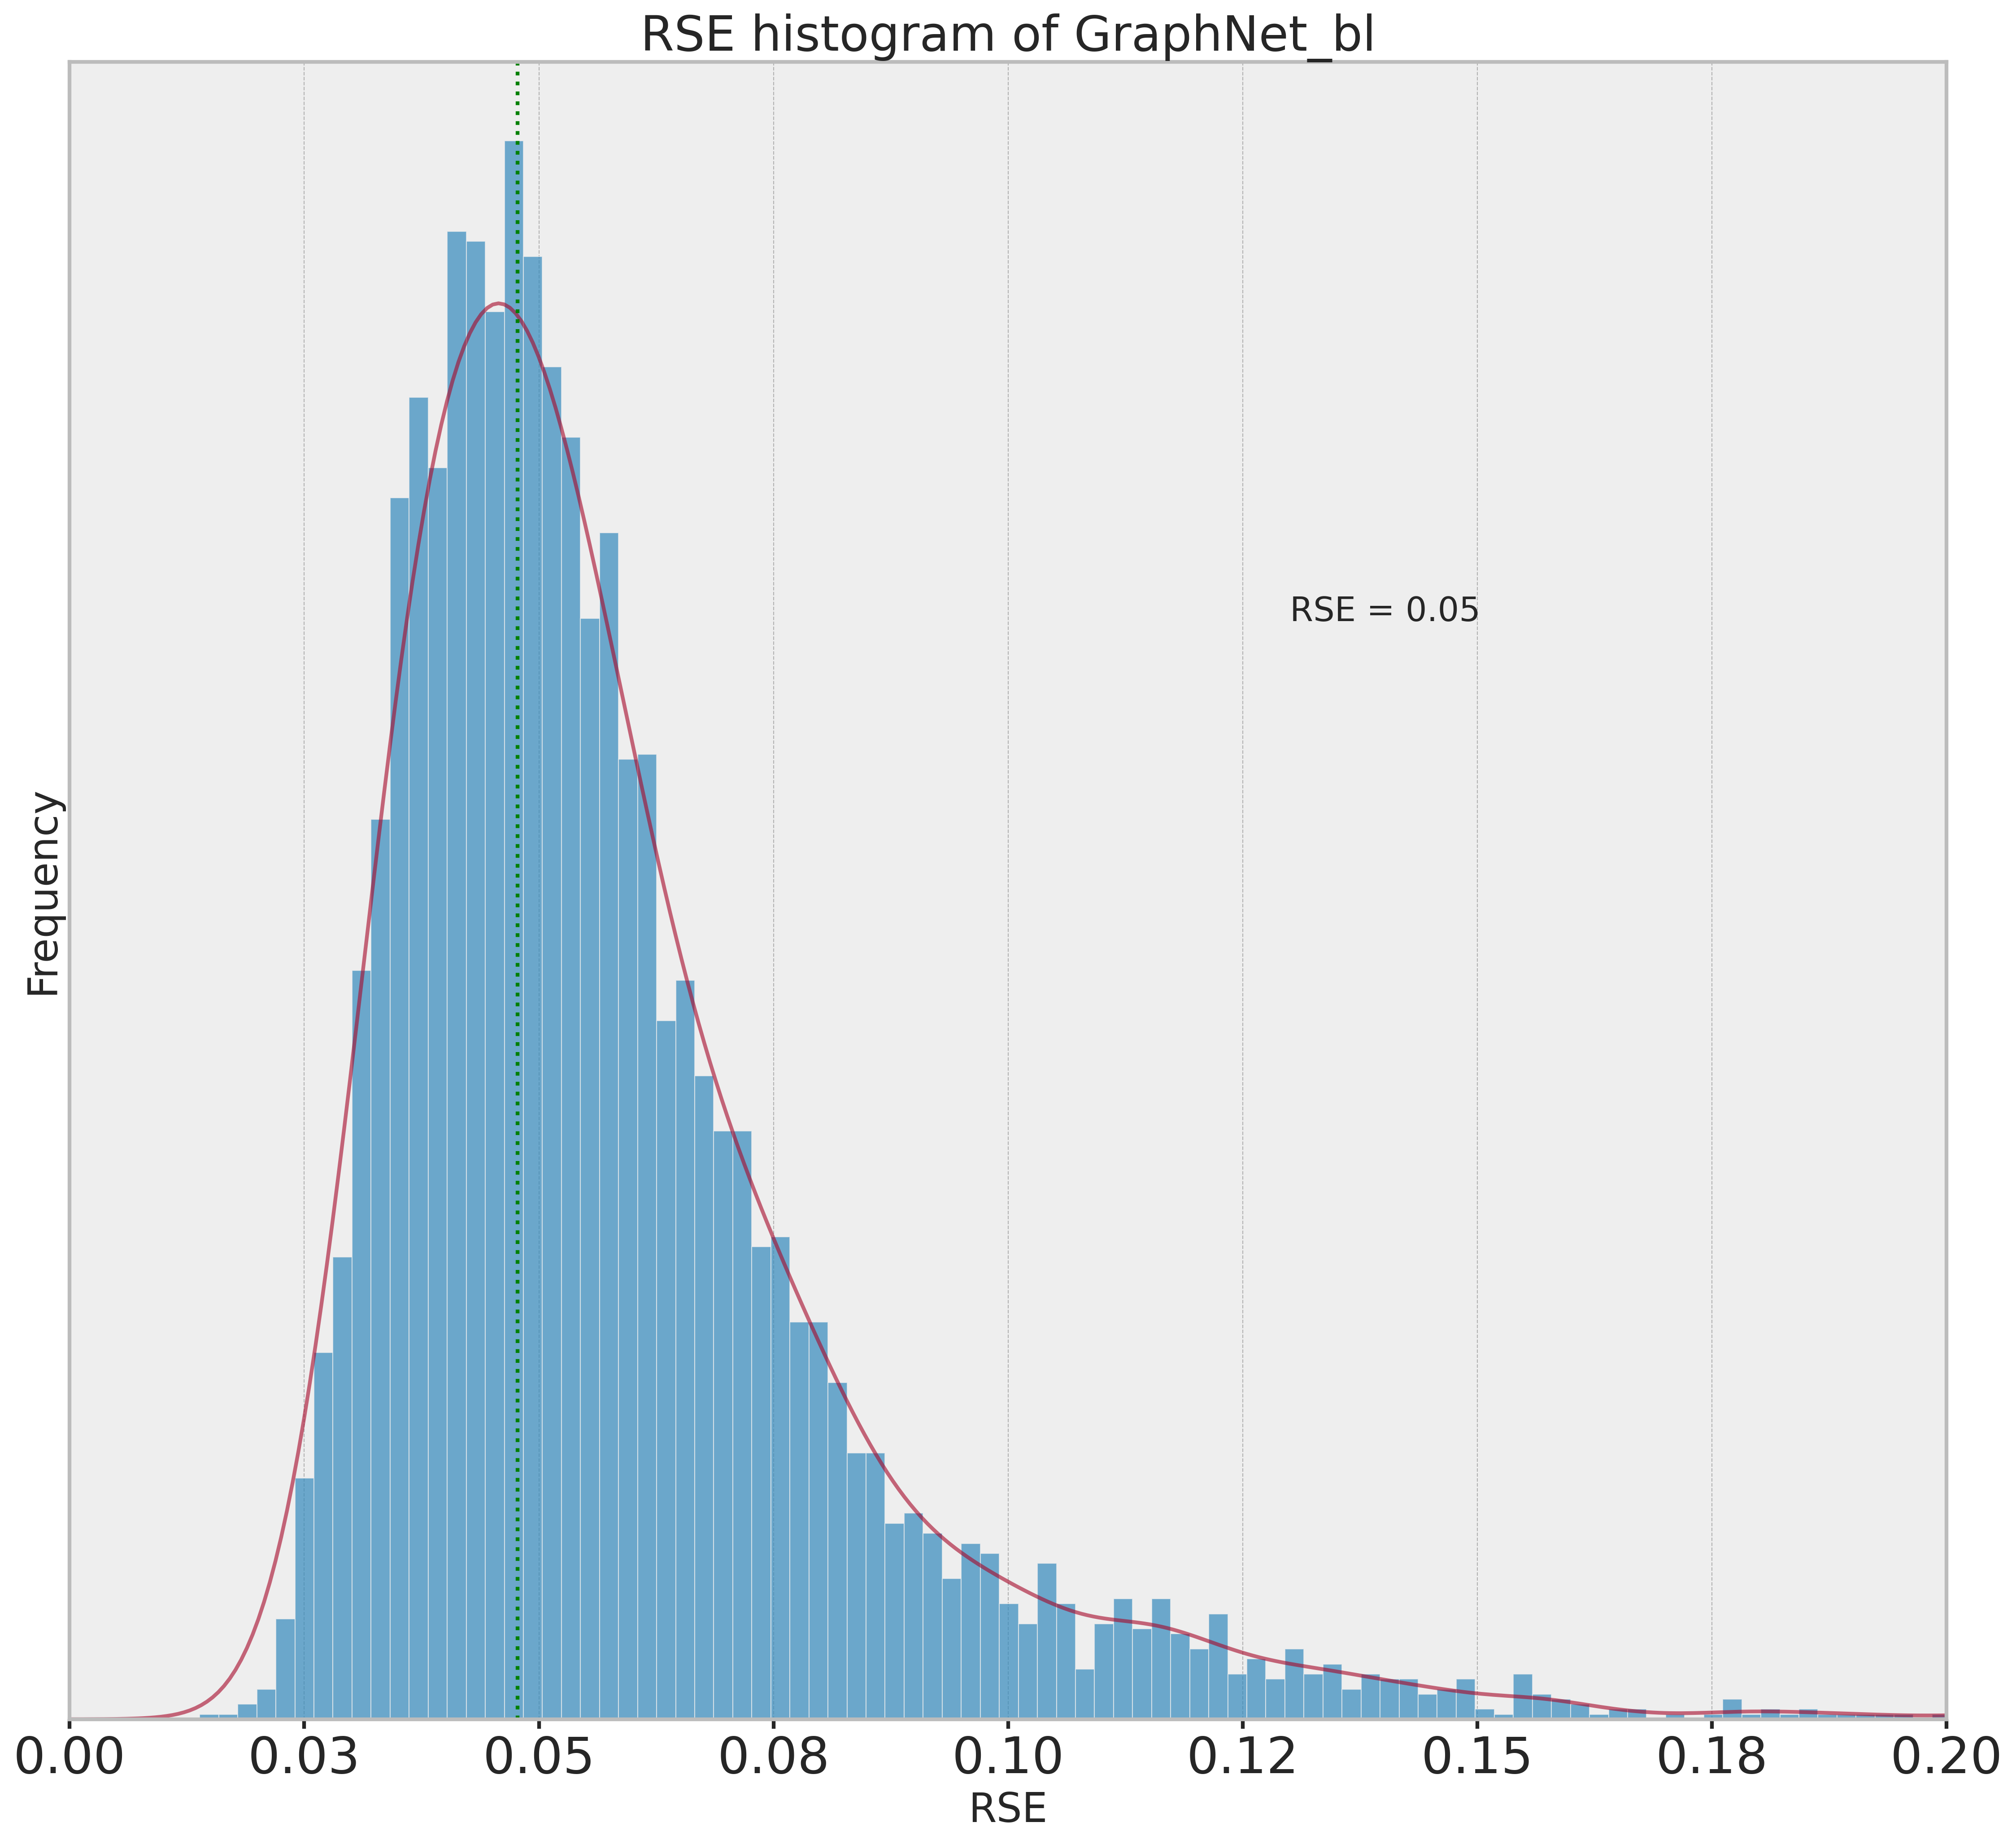

In [12]:
rse_histogram(list(rse_dict.values()), 
              bins=150, 
              quantiles=False,
              model_name="GraphNet_bl", 
              save=False)

# Obtain the worse, average and the best RSE 

In [49]:
for k, v in rse_dict.items():
    if v > 0.18 and v < 0.2:
        print(k, v)

10167 tensor(0.1831)
10244 tensor(0.1836)
10793 tensor(0.1920)
11428 tensor(0.1813)
12298 tensor(0.1822)
13052 tensor(0.1964)
13053 tensor(0.1824)
15482 tensor(0.1890)
15502 tensor(0.1830)
16884 tensor(0.1974)
17164 tensor(0.1898)
17371 tensor(0.1881)
21055 tensor(0.1807)
21242 tensor(0.1840)
22988 tensor(0.1937)
23879 tensor(0.1853)
25552 tensor(0.1925)
25608 tensor(0.1947)
27618 tensor(0.1964)
27978 tensor(0.1817)
28094 tensor(0.1834)
29153 tensor(0.1968)
30969 tensor(0.1956)
31081 tensor(0.1982)
31083 tensor(0.1906)
31432 tensor(0.1920)
36546 tensor(0.1880)
42292 tensor(0.1897)
44260 tensor(0.1852)
44712 tensor(0.1845)


In [ ]:
#{gatv2: {best: 7276, average: 1517, worse: 11197}}
#{gcn: {best: 6402, average: 6948, worse: 11212}}
#{graphnet: {best: 7385, average: 467, worse: 41219}}

# prediction on the test data

In [13]:
def prediction(
    model, 
    test_data, 
    device, 
    multi_idx:int = None,
    multiPrediction:bool = False,
    single_idx: int = None,
    marker: int = None, 
    model_path: str = None,
    save_plot: bool = False,
    graphnet: bool = False
):
    
    if model_path:
        assert model_path.endswith('.pt')
        model.load_state_dict(torch.load(model_path))
    #function to get truth and prediction from graph input
    def molecule_pred(idx:int, test_data):
        import pandas as pd
        molecule_graph = test_data[idx].to(device)
        x, edge_index = molecule_graph.x, molecule_graph.edge_index
        batch_seg = torch.tensor(np.repeat(0, x.shape[0]), device=device)
        
        model.to(device)
        model.eval()
        with torch.no_grad():
            if graphnet:
                molecule_graph.batch = batch_seg
                pred = model(molecule_graph)
            else:
                pred = model(x, edge_index, batch_seg)
            x_pred = np.linspace(270, 300, 100)
            y_pred = pred.cpu().numpy().flatten()
            y_true = test_data[idx].spectrum.cpu().numpy().flatten()
            mol_idx = np.repeat(idx, 100)
            
            df = pd.DataFrame(np.c_[x_pred, y_true, y_pred, mol_idx],
                              columns=['Energies', 'DFT/ROCIS', 'SpectraGNN', 'molecule'])
            df['SpectraGNN'] = MinMaxScaler().fit_transform(df['SpectraGNN'].values.reshape(-1, 1))
            df['DFT/ROCIS'] = MinMaxScaler().fit_transform(df['DFT/ROCIS'].values.reshape(-1, 1))
        return df 
    
    #plotting
    if multiPrediction and multi_idx:
        dfs = []
        mols_idxs = np.random.randint(0, 6000, multi_idx)
        for idx in mols_idxs:
            dfs.append(molecule_pred(idx, test_data))
        fig, axis = plt.subplots(3, 2)
        fig.text(0.51, 0.04, 'Energy (eV)', ha='center', fontsize=15)

        axis = list(axis[:, 0]) + list(axis[:, 1])

        for df, ax in zip(dfs, axis):
            ax.plot(df.Energies, df.SpectraGNN, color='r', label='prediction')
            ax.plot(df.Energies, df['DFT/ROCIS'], color='black', label='DFT/ROCIS')
            ax.legend()
            ax.set_yticklabels([])

    elif single_idx:
        df = molecule_pred(single_idx, test_data) 
        fig, ax = plt.subplots()
        ax.plot(df.Energies, df.SpectraGNN, color='r', label='prediction')
        ax.plot(df.Energies, df['DFT/ROCIS'], color='black', label='DFT/ROCIS')
        ax.legend()
        ax.set_yticklabels([])
        ax.set_xlabel('Energies (eV)')
        ax.set_ylabel('Intensity (arb. units)')
        if marker:
            ax.scatter(df.iloc[marker]['Energies'], df.iloc[marker]['DFT/ROCIS'],
                       marker="o", color="black", s=50) 
            print(df.iloc[marker]['Energies'])
    if save_plot:
        fig.savefig('./predictions.png', dpi=200)

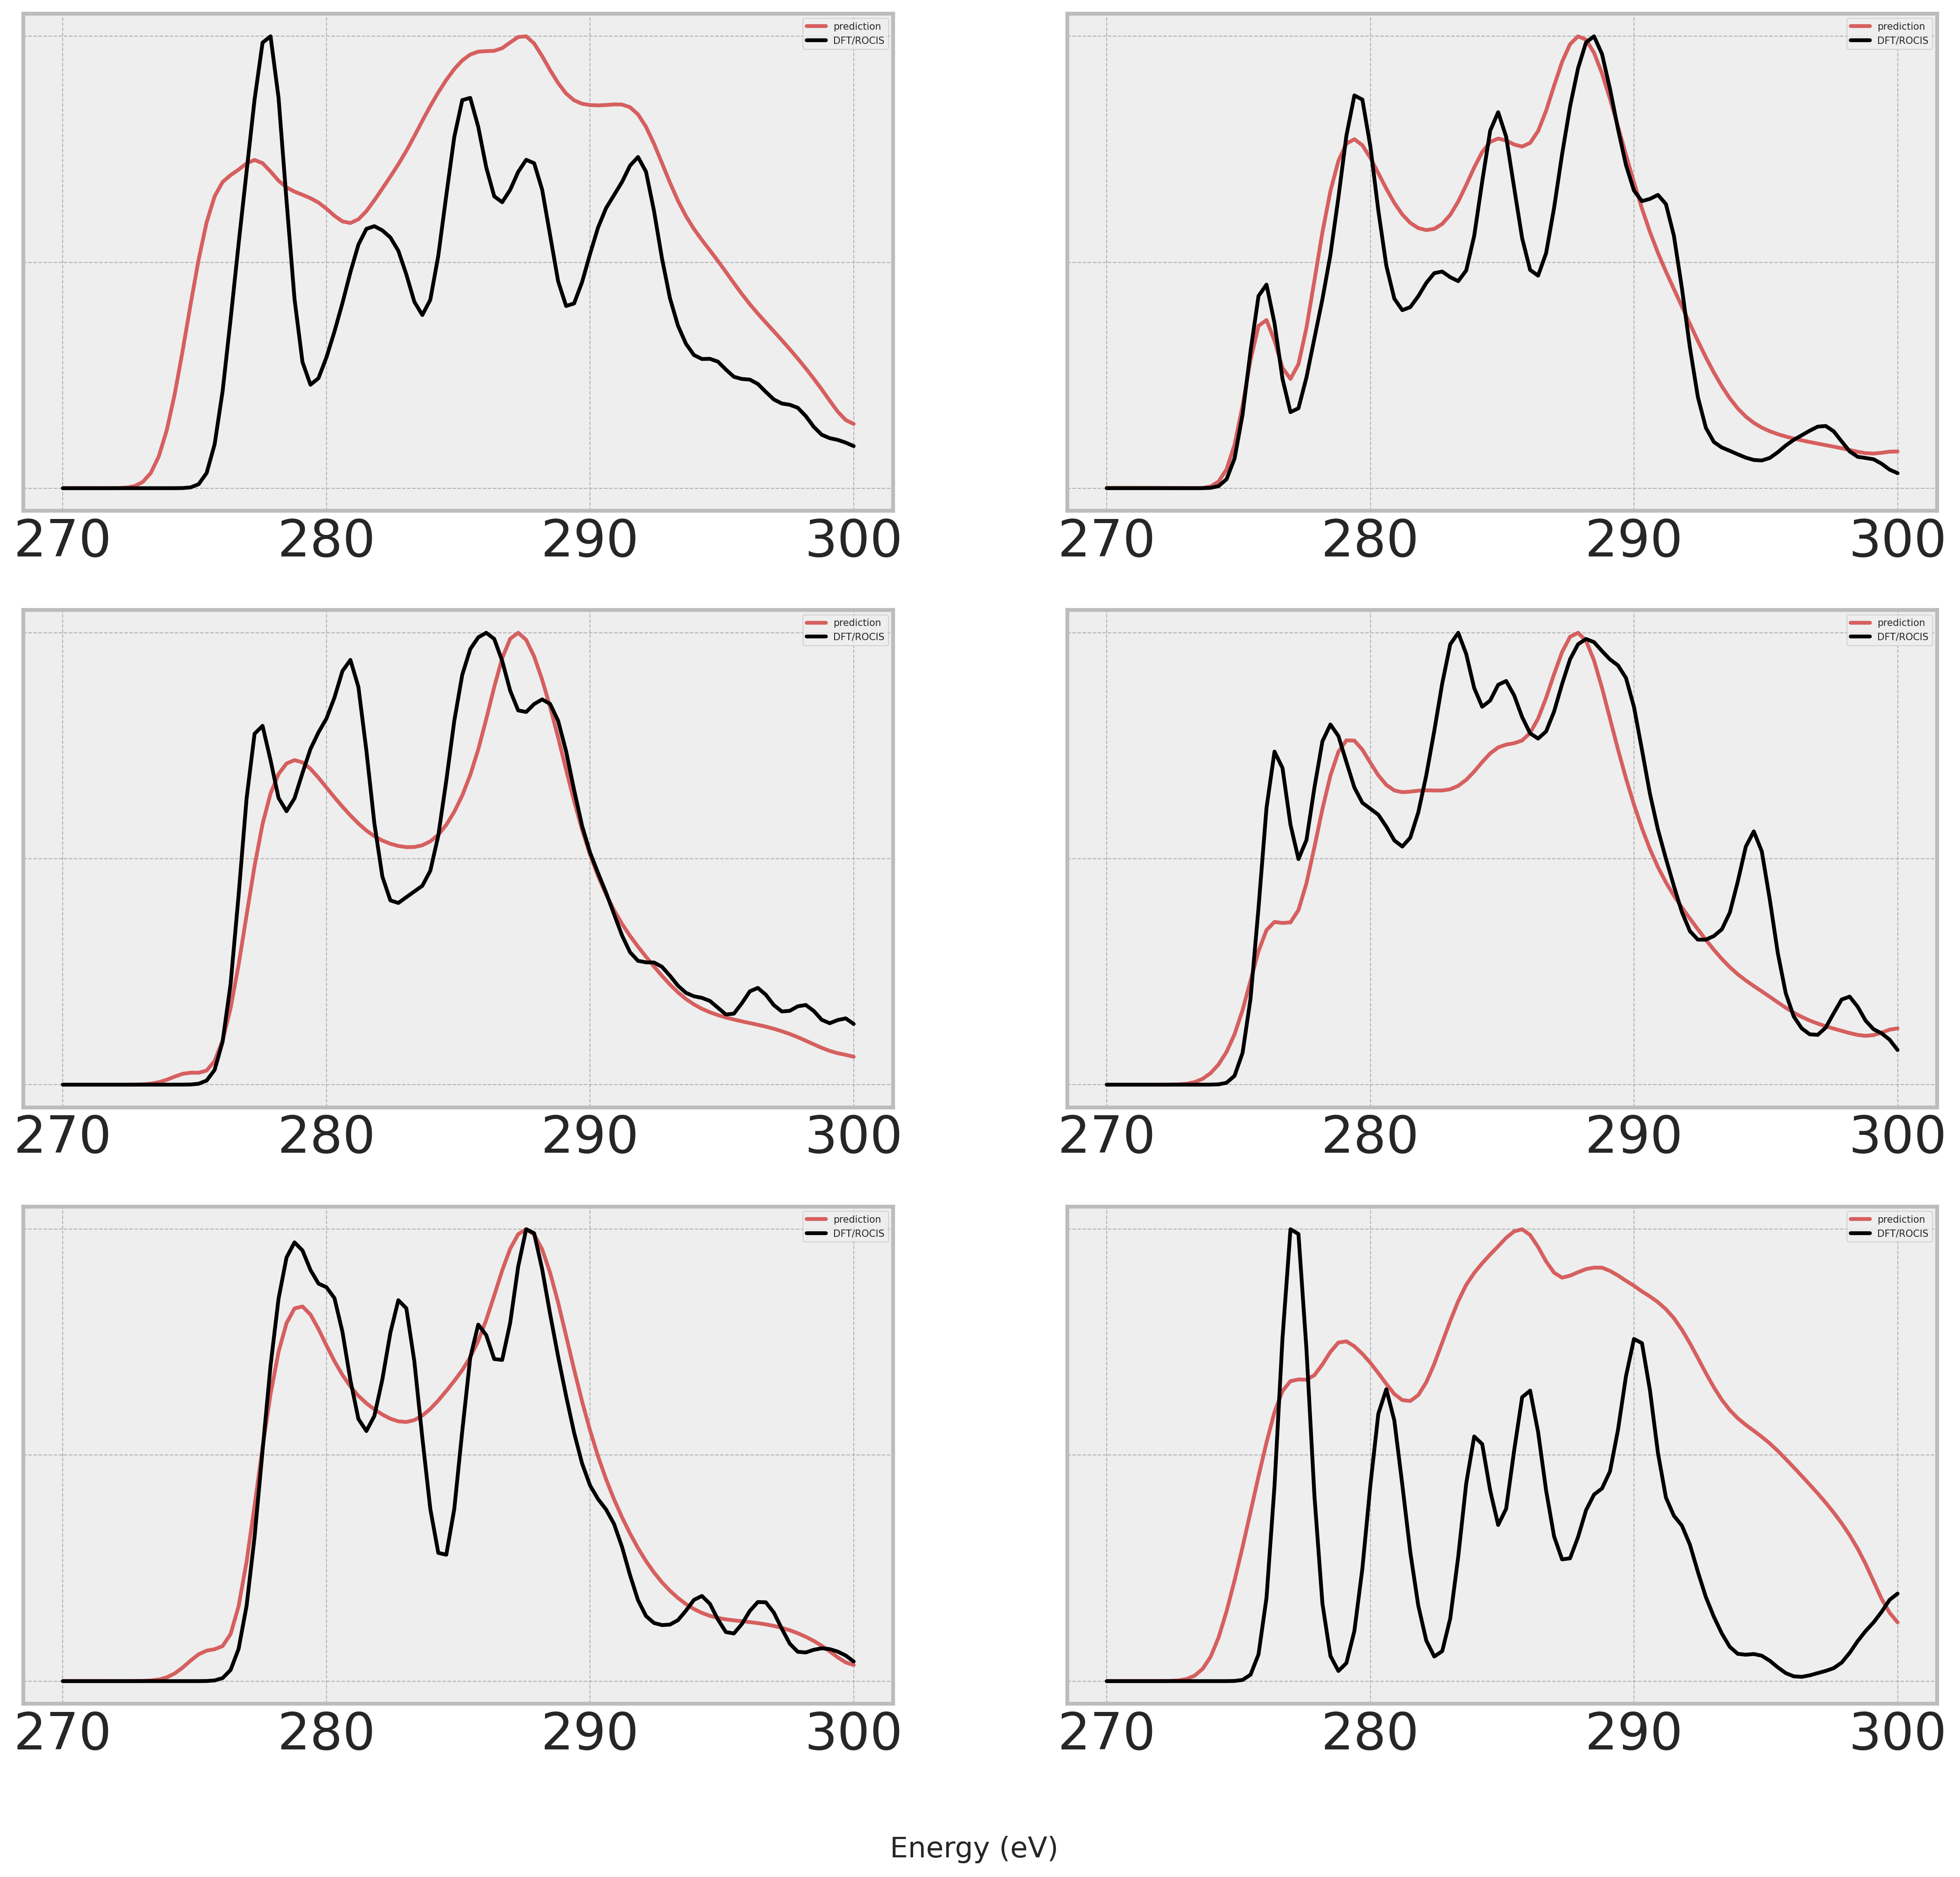

In [19]:
prediction(spectragraphnet, 
           test_data, device='cpu',
           model_path= ('/p/home/jusers/kotobi2/juwels/hida_project/trained_models/'\
                'models_diff_arch/spectragraphnet_50k_bl/best_model/spectragraphnet_50k_bl.pt'),
           multi_idx=8,
           multiPrediction=True, 
           save_plot=False,
           graphnet=True)

# single predictions

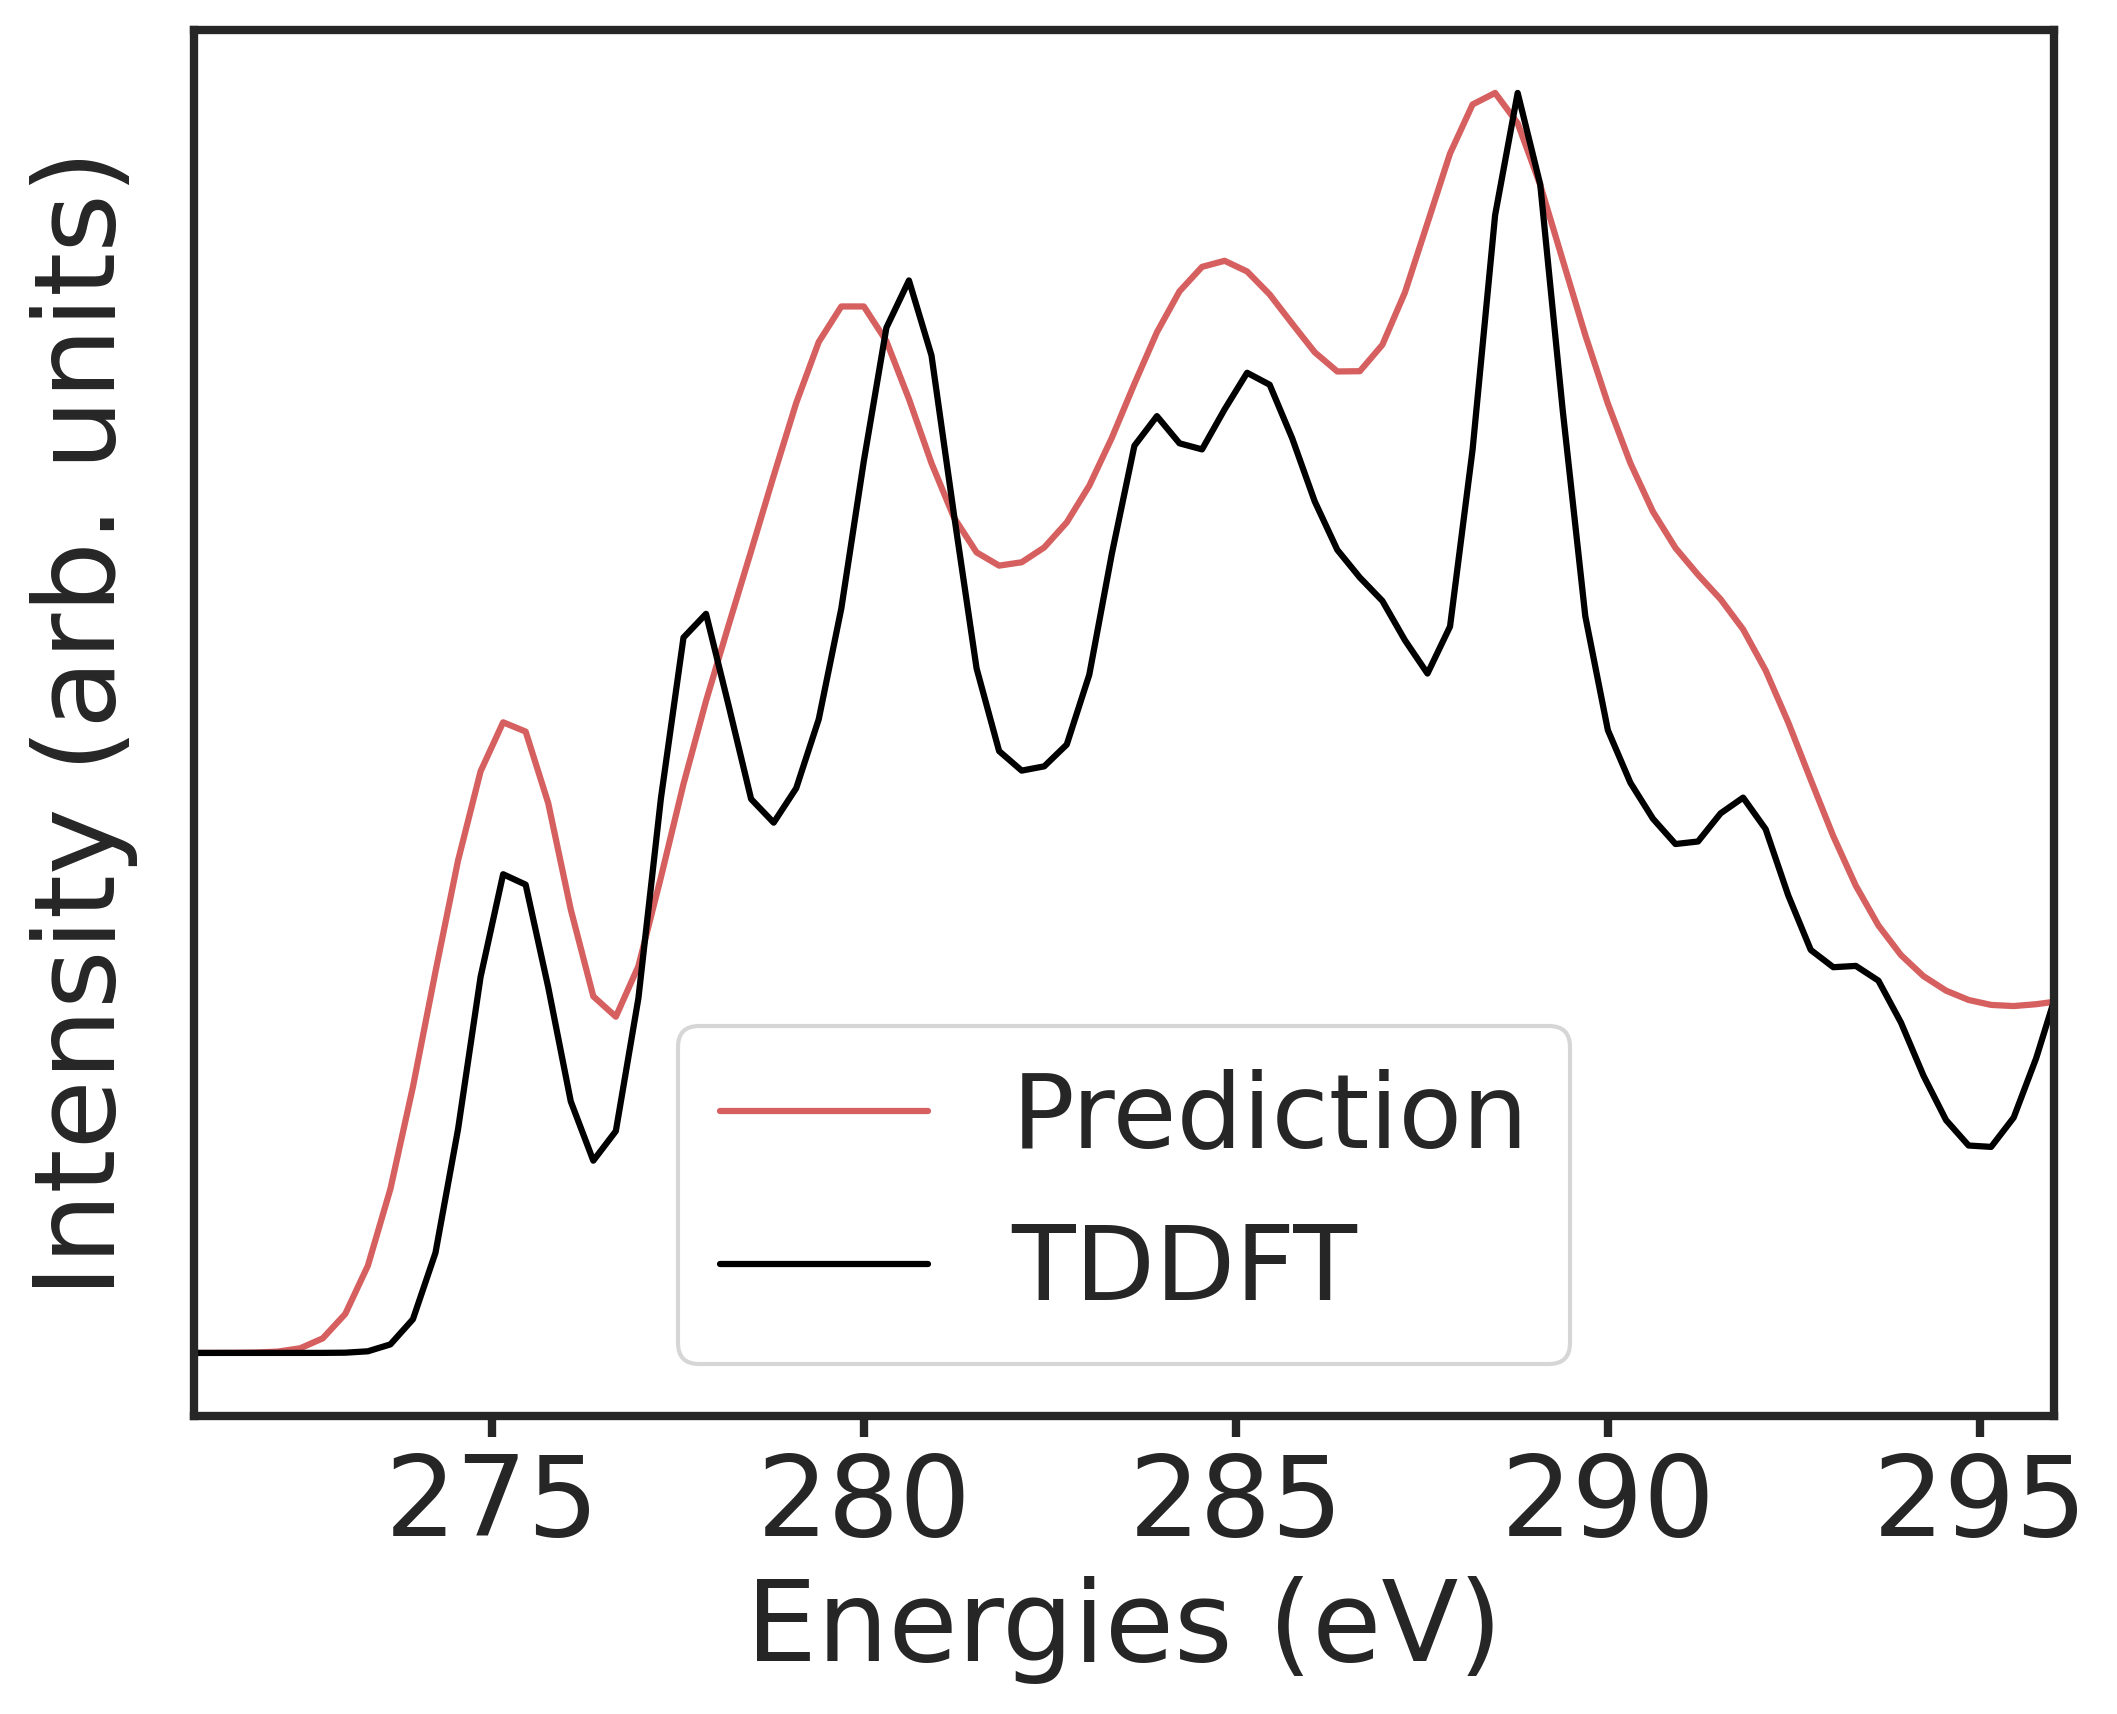

In [84]:
#standardize y pred and true 
y_pred_stand = MinMaxScaler().fit_transform(y_pred.reshape(-1, 1))
y_true_stand = MinMaxScaler().fit_transform(y_true.reshape(-1, 1))

fig, ax = plt.subplots()
ax.plot(x_pred, y_pred_stand, color='r', label='Prediction')
ax.plot(x_pred, y_true_stand, color='black', label='TDDFT')
#ax.plot(x_pred[peaks], y_pred[peaks], "x", color='red')
ax.legend()
ax.set_yticklabels([])
ax.set_xlabel('Energies (eV)')
ax.set_ylabel('Intensity (arb. units)')
ax.tick_params(axis='x', which='major', direction='out', 
               bottom=True, width=2, length=5)
ax.set_xlim(271, 296) 

plt.savefig('./spectra.png', dpi=300, bbox_inches='tight')

In [62]:
prediction(spectragat, qm9_spec_test, device='cpu',
                 model_path='./best_model/spectragat_50k.pt',
                 single_idx=3400, 
                 save_plot=False,
                 marker=59)

NameError: name 'spectragat' is not defined

In [27]:
idx_chosen = {}
file_ids = [2125, 4465, 6949, 7208, 9146]
for i, test_data in enumerate(test_qm9):
    if test_data.idx in file_ids:
        idx_chosen[test_data.idx] = i

# Obtaining the Class Activation Map (CAM) for the model

In [73]:
# single graph input
molecule_graph = test_qm9[490].to(device)
x, edge_index = molecule_graph.x, molecule_graph.edge_index
CAM_test = CAM(x, edge_index,
               spectragnn, 
               device=device,  
               best_model_path='./best_model/spectragnn_4gatv2_20k/spectragnn_20k.pt')

In [64]:
molecule_graph = test_qm9[490].to(device)
x, edge_index = molecule_graph.x, molecule_graph.edge_index
CAM_test = CAM_gat(x, edge_index,
               spectragat, 
               device=device,  
               best_model_path='./best_model/spectragat_20k.pt')

In [65]:
test_qm9[490].z

tensor([6, 6, 6, 6, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1])

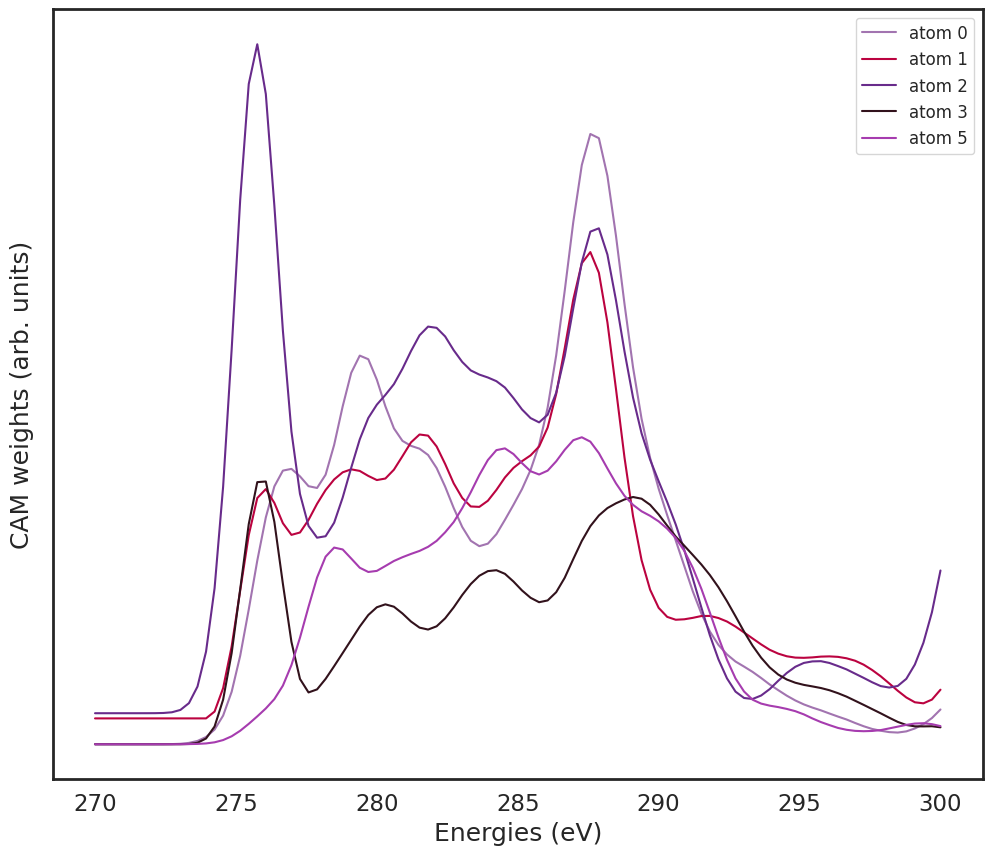

In [66]:
energies = np.linspace(270, 300, 100)
fig, ax = plt.subplots()

atoms = [0, 1, 2, 3, 5, 6]
#colors = np.random.rand(3,)
offsets =[0, 500, 600, 0, 0]
for atom, offset in zip(atoms, offsets):
    ax.plot(energies, CAM_test[atom, :].detach().cpu() + offset, 
            color=np.random.rand(3,), label=f'atom {atom}')
    ax.legend()
    ax.set_yticklabels([])
    ax.set_xlabel('Energies (eV)')
    ax.set_ylabel('CAM weights (arb. units)')
    
#fig.savefig('./CAM_weights.png', dpi=200)

# Plotting graph data

In [67]:
import matplotlib.pyplot as plt
import networkx as nx

In [68]:
def plot_graph(idx: int, energy: int, 
               test_data: List[Data], CAM_data, 
               save_plot: bool = False):
    G=nx.Graph()
    
    for i in range(test_data[idx].x.shape[0]):
        G.add_node(i)

    target = test_qm9[idx].edge_index[0].tolist()
    source = test_qm9[idx].edge_index[1].tolist()

    for i, j in zip(target, source):
        G.add_edge(i, j)
        
    
    pos_dict = {}
    for i, xyz in enumerate(test_data[idx].pos):
        pos_dict[i] = xyz[:-1].detach().cpu().numpy()
     
    pos_g=nx.spring_layout(G,pos=pos_dict)
    nx.draw_networkx(G, pos=pos_g, 
                     node_color=CAM_data[:, energy].detach().cpu().numpy(), 
                     node_size=1000, cmap=plt.cm.Reds)
    
    if save_plot:
        plt.savefig('./CAM_fig.png', dpi=300, bbox_inches='tight')

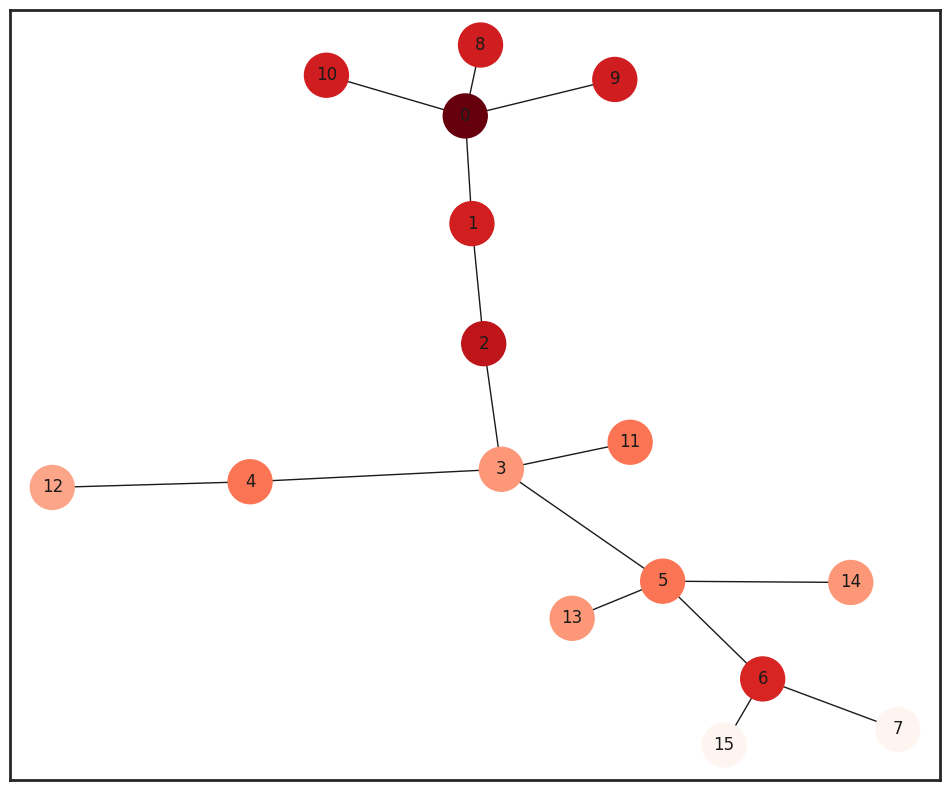

In [69]:
plot_graph(490, 59, test_qm9, CAM_test, save_plot=False)

# clustering and dimensionality reduction of CAM data

In [27]:
import hdbscan
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [23]:
all_cam_carbons = []
all_carbon_inds = []
all_mol_ids = []
for i in range(len(test_qm9)):
    molecule_graph = test_qm9[i].to(device)
    x, edge_index, z = molecule_graph.x, molecule_graph.edge_index, molecule_graph.z
    carbon_inds = torch.where(z==6)[0]
    CAM_data = CAM(x, edge_index,
                   spectragnn, 
                   device=device,  
                   best_model_path='./best_model/spectragnn_4gatv2_20k/spectragnn_20k.pt')
    all_cam_carbons.append(CAM_data[carbon_inds, :])
    all_carbon_inds.append(carbon_inds)
    all_mol_ids.append(torch.repeat_interleave(torch.tensor(i), carbon_inds.shape[0]))
all_cam_carbons = torch.cat(all_cam_carbons, 0)
all_carbon_inds = torch.cat(all_carbon_inds, 0)
all_mol_ids = torch.cat(all_mol_ids, 0)

In [51]:
all_cams = torch.vstack((all_cam_carbons.T, all_carbon_inds, all_mol_ids)).T.numpy()

In [61]:
tsne_ldData = TSNE(n_components=2, perplexity=20).fit_transform(all_cams[:, :-2])

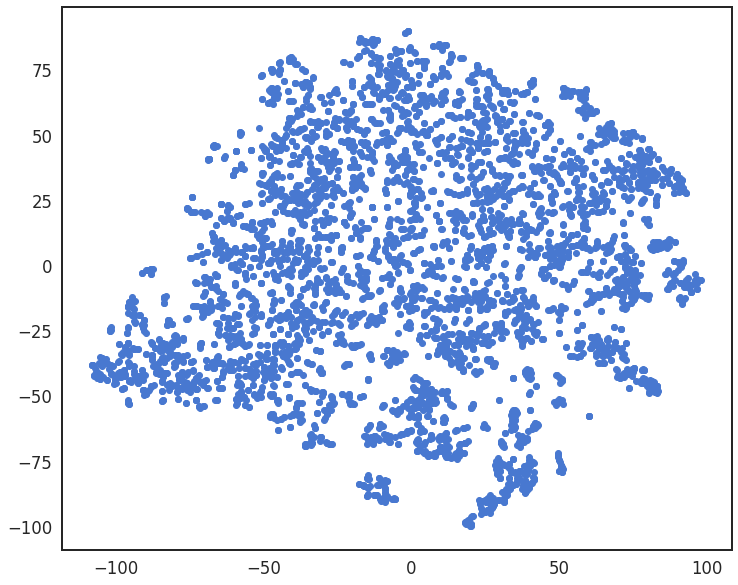

In [62]:
plt.scatter(tsne_ldData[:, 0], tsne_ldData[:, 1])

## PCA and explained variance

In [66]:
pca = PCA(n_components=15)
cam_pca = pca.fit_transform(all_cams[:, :-2])

pca.components_
np.cumsum(pca.explained_variance_ratio_)

array([0.52594745, 0.7619341 , 0.8104989 , 0.84850955, 0.88047224,
       0.9066088 , 0.92483115, 0.94246083, 0.9569003 , 0.9674138 ,
       0.97428936, 0.98050445, 0.9858346 , 0.99000466, 0.99328566],
      dtype=float32)

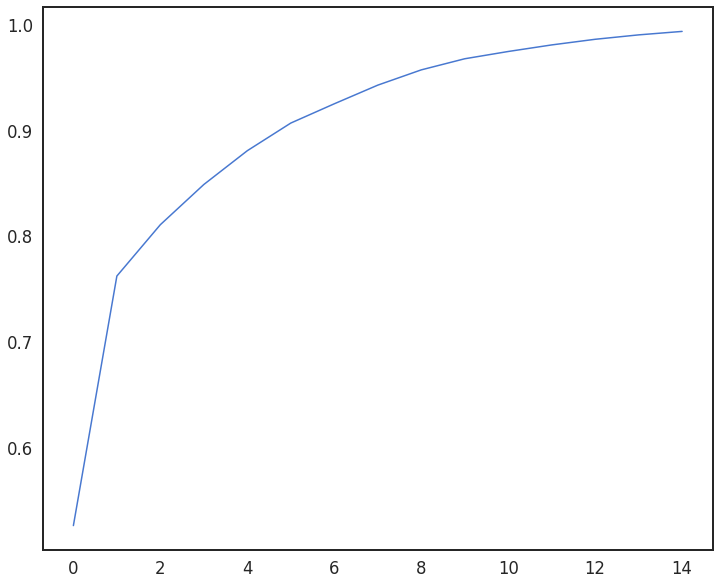

In [67]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

## HDBSCAN

In [110]:
min_cluster=6
min_samples=3

clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster, 
                            min_samples=min_samples,
                            cluster_selection_epsilon=0.5).fit(cam_pca)

In [111]:
labels = clusterer.labels_
print(max(labels))

135


In [112]:
#create a dataframe 
cam_clusters = pd.DataFrame({'x' : tsne_ldData[:, 0], 
                             'y' : tsne_ldData[:, 1],
                             'labels' : labels,
                             'cam_carbons_inds' : all_cams[:, -2], 
                            'molecule_inds' : all_cams[:, -1]})
cam_clusters.to_csv('./all_cam_data.csv')


In [113]:
cam_clusters.query('labels == 4')

,x,y,labels,cam_carbons_inds,molecule_inds
179,20.288855,-99.086716,4,6.0,32.0
636,20.256659,-99.154037,4,5.0,117.0
3771,19.813515,-99.574257,4,5.0,667.0
3772,19.666519,-99.691528,4,6.0,667.0
4382,20.216141,-99.355591,4,3.0,775.0
5259,19.996124,-99.684624,4,5.0,929.0


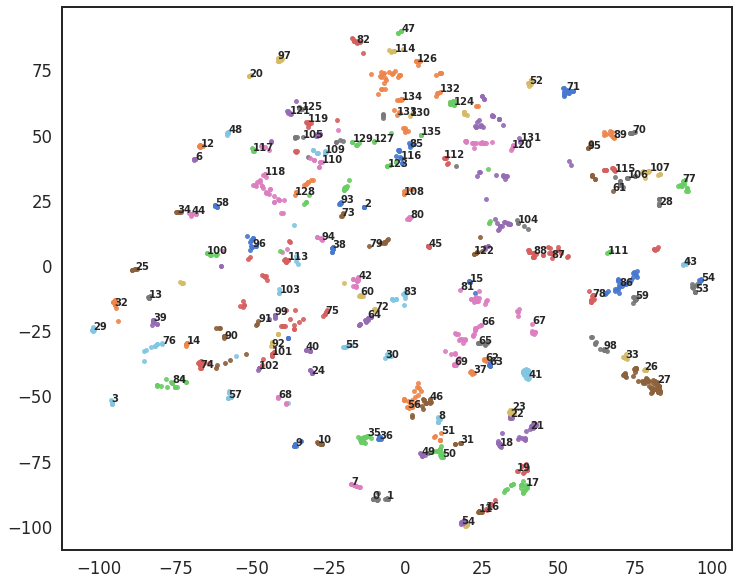

In [116]:
for label in cam_clusters.labels.unique():
    if label != -1:
        plt.scatter(x = cam_clusters.loc[cam_clusters['labels'] == label, 'x'],
                    y = cam_clusters.loc[cam_clusters['labels'] == label, 'y'],
                    s=15,
                    alpha=0.9)
        
        randm_pts = cam_clusters.loc[cam_clusters['labels'] == label].sample(1)
        
        for _, row in randm_pts.iterrows():
            plt.annotate(label, xy=(row['x'], row['y']), size=10, weight='bold')
#plt.savefig('./CAM_clusters.png', dpi=300, bbox_inches='tight')

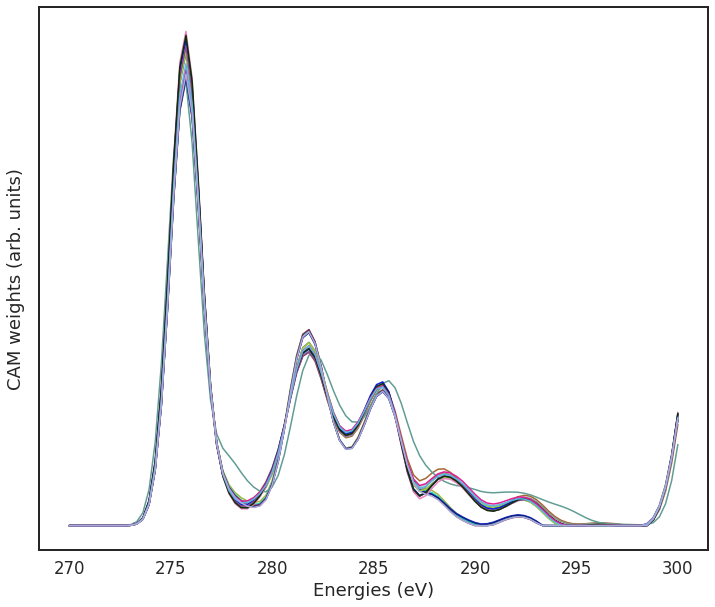

In [73]:
energies = np.linspace(270, 300, 100)
fig, ax = plt.subplots()

atoms = np.where(labels==1)[0]
#colors = np.random.rand(3,)
#offsets =[0, 500, 600, 0, 0]
for atom in atoms:
    ax.plot(energies, all_cams[atom, :-2], 
            color=np.random.rand(3,))
    #ax.legend()
    ax.set_yticklabels([])
    ax.set_xlabel('Energies (eV)')
    ax.set_ylabel('CAM weights (arb. units)')
    
#plt.savefig('./CAM_weights.png', dpi=300, bbox_inches='tight')